# Patch Wise Inference   (Please read this carefully!)

This notebook is to do inference based on the model in this github repository https://github.com/ellisdg/3DUnetCNN


## Introduction
They are doing a comparison between a 3DUnet and 3DUnet Patch Wise network and they want to demostrate that patch wise is a better sulution that unet.

<center>
<div style='display: flex;flex-wrap: wrap;'>
<figure style="float: left;">
<img src='https://www.researchgate.net/publication/327941585/figure/fig3/AS:686047130296330@1540577790472/The-architecture-of-the-patch-wise-convolutional-network-This-paper-splits-the-large.ppm'/>
<figcaption><h1>Patch Wise Unet Covolutional Network.</h1></figcaption>
</figure>

<figure style="float: right;">
<img src='https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6210727/bin/sensors-18-03232-g001.jpg'/>
<figcaption><h1> Patch Wise Model Training and Evaluation.</h1></figcaption>
</figure>
</div>
</center>


## Loss and Metrics
For this purpose they are using Dice like a loss function and Dice Coefficient like a metric for performace. (<a href='https://medium.com/datadriveninvestor/deep-learning-in-medical-imaging-3c1008431aaf'>Explanation here</a>)


## Preprocessing

They are using a set of tools to do preprocessing, like a for example <a href='https://itk.org/'>https://itk.org/</a> and <a href='https://github.com/ANTsX/ANTs#advanced-normalization-tools'>Ants</a>
that should be installed for training or inference.

Also they have they own set of functions to help to reescale, resize, normalize and standarize the cubes of data.


## IPyWidget Viewer 

I did a viewer using ipywidgets that allows to visualize the results, with the slider you can move the deepth in the z-axis


In [1]:
import ipywidgets as widgets
from ipywidgets import FloatSlider
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Layout
from IPython.display import display,clear_output
from IPython.display import display
import IPython
from ipywidgets import Output

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import numpy as np
import imutils
import cv2
import pandas as pd

from unet3d.training import load_old_model
from unet3d.prediction import predict, patch_wise_prediction, prediction_to_image
from unet3d.normalize import normalize_data_storage
from unet3d.utils.utils import get_affine, read_image

from brats.train import config
from brats.preprocess import  normalize_image

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


%matplotlib inline

Using TensorFlow backend.
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Fu

200218-12:13:51,319 nipype.utils INFO:
	 Running nipype version 1.4.0 (latest: 1.4.2)


# Required to run on RXT GPU Cards

In [2]:
gpu_config = ConfigProto()
gpu_config.gpu_options.allow_growth = True
session = InteractiveSession(config=gpu_config)

# Creating a viewer

In [3]:
class viewer:
    def __init__(self, img,pred):
        self.tab = widgets.Tab()
        self.childrens = []
        self.tab.children = []
        self.tab.set_title(0, 'Segmentation')
        self.tab.set_title(1, 'Nifti Information')
        self.mri_img = img
        self.mri_prediction = pred #resize(pred,self.mri_img.pixel_array.shape)  #np.zeros(512*512).reshape((512,512))
        
        self.mri_payload = self.mri_img #np.array(self.mri_img.dataobj)#np.copy(self.mri_img.pixel_array)
        self.mri_slide = self.mri_payload[:,:,10] 
        self.mri_pred_slide = self.mri_prediction[:,:,10] 
        
        
        self.tab_segmentation()
        self.tab_dicominformation()
        self.display()
        
    def tab_segmentation(self):
        self.mri_slider = widgets.IntSlider(min=0, max=self.mri_payload.shape[2]-1, step=1,value=10,orientation='vertical',description='Deep',layout=Layout(width='150px'))
        self.out_mri = widgets.Output(layout=Layout(height='{}px'.format(self.mri_slide.shape[0]), width = '{}px'.format(self.mri_slide.shape[1]), border='None'))
        self.out_prediction = widgets.Output(layout=Layout(height='{}px'.format(self.mri_slide.shape[0]), width = '{}px'.format(self.mri_slide.shape[1]), border='None'))
        self.out_overlap = widgets.Output(layout=Layout(height='{}px'.format(self.mri_slide.shape[0]), width = '{}px'.format(self.mri_slide.shape[1]), border='None'))
        scale=4
        def update_mri_plot(value):
            self.mri_slide = self.mri_payload[:,:,value]
            fig, axes = plt.subplots()
            axes.set_title('Original MRI')
            dpi = fig.get_dpi()
            fig.set_size_inches(self.mri_slide.shape[0]/float(dpi)*scale,self.mri_slide.shape[1]/float(dpi)*scale)
            axes.imshow(self.mri_slide,cmap='bone')
            plt.show(fig)
                    
            
        def plot_overlap(value):
            fig, axes = plt.subplots()
            axes.set_title('Overlap')
            dpi = fig.get_dpi()
            fig.set_size_inches(self.mri_prediction.shape[0]/float(dpi)*scale,self.mri_prediction.shape[1]/float(dpi)*scale)
            axes.imshow(self.mri_slide+ self.mri_pred_slide*np.max(self.mri_slide))
            plt.show(fig)
            
        def plot_prediction(value):
            self.mri_pred_slide = self.mri_prediction[:,:,value]
            img = self.mri_pred_slide #resize(self.mri_prediction,self.mri_img.pixel_array.shape) 
            fig, axes = plt.subplots()
            axes.set_title('Prediction')
            dpi = fig.get_dpi()
            fig.set_size_inches(self.mri_prediction.shape[0]/float(dpi)*scale,self.mri_prediction.shape[1]/float(dpi)*scale)
            axes.imshow(self.mri_pred_slide)
            #axes.imshow(self.mri_pred_slide)
            plt.show(fig)
                    
        with self.out_mri :
            img0 = interactive(update_mri_plot, value=self.mri_slider)
            self.mri_slider.value=13
        
        
        with self.out_prediction :
            img2 = interactive(plot_prediction, value=self.mri_slider)
            self.mri_slider.value=11
        
        with self.out_overlap :
            img3 = interactive(plot_overlap, value=self.mri_slider)
            self.mri_slider.value=10
                
            
        self.hbox=widgets.HBox([img0.children[0],img0.children[1],img2.children[1],img3.children[1]])

        self.childrens.append(self.hbox) 
        
    def tab_dicominformation(self):
        pass
    def display(self):
        #self.tab.children = self.childrens
        display(self.hbox)


# Plotting Training/Validation results

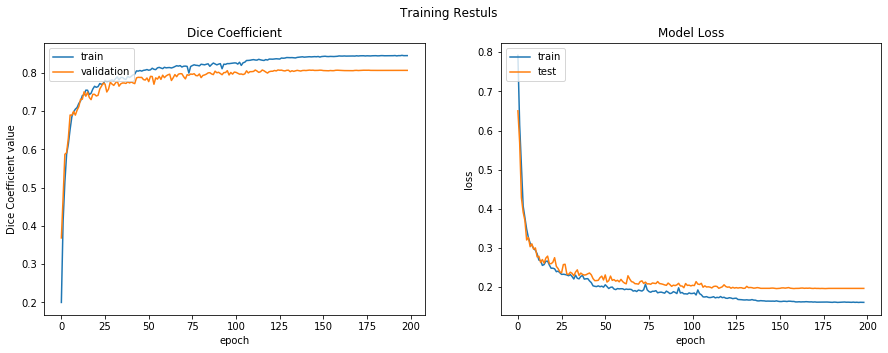

In [4]:
trainig_history=pd.read_csv('training.log')
trainig_history
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Training Restuls')
#plt.figure(figsize=(30,20))
# summarize history for accuracy
ax1.plot(trainig_history['epoch'].values,trainig_history['dice_coefficient'].values)
ax1.plot(trainig_history['epoch'].values,trainig_history['val_dice_coefficient'].values)
ax1.set_title('Dice Coefficient')
ax1.set_ylabel('Dice Coefficient value')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
#plt.show()
# summarize history for loss
ax2.plot(trainig_history['epoch'].values,trainig_history['loss'].values)
ax2.plot(trainig_history['epoch'].values,trainig_history['val_loss'].values)
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()


# Loading the pre-trained model

In [5]:
model=load_old_model('brast-models/model-unet.h5')

Loading pre-trained model



# Data Preparation for prediction (read this very carefull!)

This is a multiclass segmentation model, the input data for the model are four cubes of data then
the Input Shape is (4, 128, 128, 128), 4 channels ["t1", "t1ce", "flair", "t2"]

The output are labels 1,2,4 (this will be fixed when I train it again)

labels explanation:
* GD-enhancing tumor (ET — label 4)
* The peritumoral edema (ED — label 2)
* Non-enhancing tumor (NCR/NET — label 1)



<h1 style="color: red;"> That means that to evaluate the data of a patient in the hostpital we will need the four images ("t1", "t1ce", "flair", "t2") for a single patient</h1>



In [6]:
# raw input files
mri_file_t1    = 'brast-validation/2019/MICCAI_BraTS_2019_Data_Validation/BraTS19_CBICA_AAM_1/BraTS19_CBICA_AAM_1_t1.nii.gz'
mri_file_t1ce  = 'brast-validation/2019/MICCAI_BraTS_2019_Data_Validation/BraTS19_CBICA_AAM_1/BraTS19_CBICA_AAM_1_t1ce.nii.gz'
mri_file_flair = 'brast-validation/2019/MICCAI_BraTS_2019_Data_Validation/BraTS19_CBICA_AAM_1/BraTS19_CBICA_AAM_1_flair.nii.gz'
mri_file_t2    = 'brast-validation/2019/MICCAI_BraTS_2019_Data_Validation/BraTS19_CBICA_AAM_1/BraTS19_CBICA_AAM_1_t2.nii.gz'

# output with bias correction using itk/ants
mri_file_t1_out    = 'brast-validation/output/data/valid/preprocessed/BraTS19_CBICA_AAM_1_t1_out.nii.gz'
mri_file_t1ce_out  = 'brast-validation/output/data/valid/preprocessed/BraTS19_CBICA_AAM_1_t1ce_out.nii.gz'
mri_file_flair_out = 'brast-validation/output/data/valid/preprocessed/BraTS19_CBICA_AAM_1_flair_out.nii.gz'
mri_file_t2_out    = 'brast-validation/output/data/valid/preprocessed/BraTS19_CBICA_AAM_1_t2_out.nii.gz'

#mri_file_t1_out = mri_file_t1
#mri_file_t1ce_out = mri_file_t1ce
#mri_file_flair_out = mri_file_flair
#mri_file_t2_out = mri_file_t2

# Bias normalization
this use to take a lot of time, we need to do it just one time with all the dataset.

In [7]:
normalize_ants=False

if normalize_ants:
    normalize_image(mri_file_t1,mri_file_t1_out)
    normalize_image(mri_file_t1ce,mri_file_t1ce_out)
    normalize_image(mri_file_flair,mri_file_flair_out)
    normalize_image(mri_file_t2,mri_file_t2_out)



# Reading images

the pre-trained model <a href='https://github.com/ellisdg/3DUnetCNN#pre-trained-models'>https://github.com/ellisdg/3DUnetCNN#pre-trained-models</a>
was trained with a input shape of (128,128,128) for every category  ["t1", "t1ce", "flair", "t2"],
the read_image function allows to read and resize the cube of data.

The final shape for the event(Tensor) to be evaluate should be (4,128,128,128)




In [8]:
dim_size=240
img_shape=(dim_size,dim_size,dim_size)

mri_t1=read_image(mri_file_t1_out,img_shape)
mri_t1ce=read_image(mri_file_t1ce_out,img_shape)
mri_flair=read_image(mri_file_flair_out,img_shape)
mri_t2=read_image(mri_file_t2_out,img_shape)
#mri_label = read_image(label_file,img_shape)


mri_t1=np.array(mri_t1.dataobj)
mri_t1ce=np.array(mri_t1ce.dataobj)
mri_flair=np.array(mri_flair.dataobj)
mri_t2=np.array(mri_t2.dataobj)
#mri_label = np.array(mri_label.dataobj)

print(mri_t1.shape)
print(mri_t1ce.shape)
print(mri_flair.shape)
print(mri_t2.shape)
#print(mri_label.shape)


Reading: brast-validation/output/data/valid/preprocessed/BraTS19_CBICA_AAM_1_t1_out.nii.gz
Reading: brast-validation/output/data/valid/preprocessed/BraTS19_CBICA_AAM_1_t1ce_out.nii.gz
Reading: brast-validation/output/data/valid/preprocessed/BraTS19_CBICA_AAM_1_flair_out.nii.gz
Reading: brast-validation/output/data/valid/preprocessed/BraTS19_CBICA_AAM_1_t2_out.nii.gz
(240, 240, 240)
(240, 240, 240)
(240, 240, 240)
(240, 240, 240)


# Standarization
they call it normalization but it is more like a data standarization 
because they are subtranting the mean and dividing by the standar deviation  

their code snippet
```py
def normalize_data(data, mean, std):
    data -= mean[:, np.newaxis, np.newaxis, np.newaxis]
    data /= std[:, np.newaxis, np.newaxis, np.newaxis]
    return data
```

In [9]:
normalize_data=True
if normalize_data:
    data_storage = normalize_data_storage(np.array([[mri_t1],[mri_t1ce],[mri_flair],[mri_t2]]))
    mri_t1    = data_storage[0,0,:,:,:]
    mri_t1ce  = data_storage[1,0,:,:,:]
    mri_flair = data_storage[2,0,:,:,:]
    mri_t2    = data_storage[3,0,:,:,:]


# Creating the event

The four cube of images(["t1", "t1ce", "flair", "t2"]) in a single tensor.

Shape (4,128,128,128)

In [10]:
event=np.array([mri_t1,mri_t1ce,mri_flair,mri_t2])
print(event.shape)

(4, 240, 240, 240)


# Prediction

I am using the default parameters that they are using for training, 
you can see that in config dictionary import it from the treining module.
```
from brats.train import config
```


In [11]:
threshold=0.5
output_label_map=True
affine = get_affine(mri_file_t1)
event=np.asarray([[mri_t1,mri_t1ce,mri_flair,mri_t2]])
prediction = patch_wise_prediction(model=model, data=event, overlap=config["validation_patch_overlap"], permute=config['permute'])[np.newaxis]
prediction_image = prediction_to_image(prediction, affine, label_map=output_label_map, threshold=threshold,labels=config["labels"])


Reading: brast-validation/2019/MICCAI_BraTS_2019_Data_Validation/BraTS19_CBICA_AAM_1/BraTS19_CBICA_AAM_1_t1.nii.gz


In [20]:
plabel2 = prediction[0,0,:,:,:]
plabel4 = prediction[0,1,:,:,:]
#plabel2 = prediction_image.dataobj
#plabel4 = prediction_image.dataobj


In [12]:
prediction_image.dataobj.shape

(240, 240, 240)

# Results Visualization 

using the viewer that I did, you can to visualize the results,
maybe you can play in the prediction cell with the parameters to get better results or you can to post process it to filter some noise.

# Results label 4 (GD-enhancing tumor)

In [21]:
viewer(mri_t1,plabel4)

# Results label 2 (The peritumoral edema)

In [22]:
viewer(mri_t1,plabel2)

# All together

In [23]:
viewer(mri_t1,plabel2+(plabel4*2))

# 3D Visualization using ipyvolume

In [24]:
import ipyvolume as ipv
import ipyvolume.pylab as p3

In [25]:
ipv.figure()
ipv.volshow(plabel2)
ipv.show()

/root/.local/lib/python3.6/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [26]:
ipv.figure()
ipv.volshow(plabel4)
ipv.show()

In [27]:
ipv.figure()
ipv.volshow(mri_t1*0.6+plabel4*500+plabel2*255)
ipv.show()